In [47]:
import pandas as pd
from jiwer import wer # функция  для расчёта процента ошибок слов (Word Error Rate, WER) 
import os
import numpy as np
import scipy.io.wavfile
from scipy.io import wavfile
from tqdm import tqdm
import librosa
import requests
import aiohttp
import asyncio

import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm


### Загрузка данных, вычисление WER

In [2]:
# Загрузка данных из файла Excel
wer1 = pd.read_excel('hackaton_result_dataset.xlsx', usecols=['model_annotation', 'human_markup', 'audio_path', 'label'])

# Вывод первых нескольких строк DataFrame для проверки
# print(wer1.head())

Здесь добавляется новая колонка 'wer' в DataFrame df.  
Метод apply используется с лямбда-функцией, которая берёт каждую строку DataFrame  
и применяет функцию wer к столбцам 'human_markup' и 'model_annotation' этой строки.  
Параметр axis=1 указывает, что функция должна быть применена к каждой строке (вместо каждого столбца).  

In [3]:
# Вычисление WER
wer1['wer'] = wer1.apply(lambda row: wer(row['human_markup'], row['model_annotation']), axis=1)

# Замена полного пути файла на имя файла
wer1['audio_path'] = wer1['audio_path'].apply(lambda x: os.path.basename(x))

# Вывод первых нескольких строк DataFrame для проверки изменений
wer1.head()


,model_annotation,human_markup,audio_path,label,wer
0,давай по россии значит на коленях быстро блять...,давай проси значит на коленях быстро блять,05a8baf22e2a.wav,1,0.428571
1,ну разве можно так с телефоном поступает,ну что ну разве можно так с телефоном поступать,05a5a51a1e9a.wav,0,0.333333
2,у меня нет с собой в полном адресе я щас дома ...,у меня нет с собой полного адреса я щас из дом...,05a4c4f90c59.wav,0,0.323529
3,а я здесь кто я санитар,а я знаешь кто я санитар,059d08276851.wav,0,0.166667
4,дежурный по кузьминскому военнокомату,дежурный по кузьминскому военкомату,059af3258ca9.wav,0,0.250000


In [4]:
wer1.tail()

,model_annotation,human_markup,audio_path,label,wer
6503,это студия,вот это не твое дело стой,67101cf5e309.wav,1,0.833333
6504,потише говори у меня рядом течение вдруг сидит...,блять ну ты потише говори у меня рядом чеченец...,670f872d266e.wav,0,0.384615
6505,если в поймаю дай бог а зачем тогда будешь рез...,если поймаю их дай а чем ты будешь меня резать...,670c59d9fd7f.wav,1,0.772727
6506,а ты все удобром что ли а че будет алло алло т...,а ты че там в гудок прям чтоли а че ало ало ты...,670b90e28bae.wav,1,0.562500
6507,вы я так понимаю в не адекватном состоянии что...,вы и этот понимаю в неадекватном состоянии чт...,670b16824714.wav,1,0.428571


### Шаги для оценки SNR:
- Определяем "тихие" участки файла, которые можно считать шумом. 
- Вычисляем среднеквадратичные значения (RMS) для шума и всего сигнала. 
- Расчитываем SNR. 

In [5]:
def calculate_snr(file_path):
    try:
        # Загрузка аудиофайла
        rate, data = scipy.io.wavfile.read(file_path)
        
        # Переводим стерео в моно, если необходимо
        if len(data.shape) == 2:
            data = np.mean(data, axis=1)
        
        # Нормализуем данные
        data = data / np.max(np.abs(data))
        
        # Определяем порог шума (например, 10% максимальной амплитуды)
        threshold = 0.1
        
        # Шумовые участки
        noise_samples = data[np.abs(data) < threshold]
        
        # Рассчитываем RMS шума и RMS сигнала
        rms_noise = np.sqrt(np.mean(noise_samples**2))
        rms_signal = np.sqrt(np.mean(data**2))
        
        # Рассчитываем SNR
        snr = 20 * np.log10(rms_signal / rms_noise)
        return snr
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return np.nan

In [6]:
# Формируем полный путь к файлам
base_path = os.path.join(os.getcwd(), 'filter_audio')
wer1['audio_path_full'] = wer1['audio_path'].apply(lambda x: os.path.join(base_path, x))

# Вычисляем SNR и сохраняем в новый столбец 'snr' с отображением прогресса
tqdm.pandas(desc="Calculating SNR")
wer1['snr'] = wer1['audio_path_full'].progress_apply(calculate_snr)

# Проверяем результат
wer1.head()

Calculating SNR: 100%|██████████| 6508/6508 [00:51<00:00, 127.19it/s]


,model_annotation,human_markup,audio_path,label,wer,audio_path_full,snr
0,давай по россии значит на коленях быстро блять...,давай проси значит на коленях быстро блять,05a8baf22e2a.wav,1,0.428571,c:\Users\User\Documents\MFTI_2 practice\filter...,11.559509
1,ну разве можно так с телефоном поступает,ну что ну разве можно так с телефоном поступать,05a5a51a1e9a.wav,0,0.333333,c:\Users\User\Documents\MFTI_2 practice\filter...,12.490909
2,у меня нет с собой в полном адресе я щас дома ...,у меня нет с собой полного адреса я щас из дом...,05a4c4f90c59.wav,0,0.323529,c:\Users\User\Documents\MFTI_2 practice\filter...,12.816182
3,а я здесь кто я санитар,а я знаешь кто я санитар,059d08276851.wav,0,0.166667,c:\Users\User\Documents\MFTI_2 practice\filter...,20.201228
4,дежурный по кузьминскому военнокомату,дежурный по кузьминскому военкомату,059af3258ca9.wav,0,0.250000,c:\Users\User\Documents\MFTI_2 practice\filter...,10.614436


In [7]:
wer1.tail()

,model_annotation,human_markup,audio_path,label,wer,audio_path_full,snr
6503,это студия,вот это не твое дело стой,67101cf5e309.wav,1,0.833333,c:\Users\User\Documents\MFTI_2 practice\filter...,19.301865
6504,потише говори у меня рядом течение вдруг сидит...,блять ну ты потише говори у меня рядом чеченец...,670f872d266e.wav,0,0.384615,c:\Users\User\Documents\MFTI_2 practice\filter...,15.048710
6505,если в поймаю дай бог а зачем тогда будешь рез...,если поймаю их дай а чем ты будешь меня резать...,670c59d9fd7f.wav,1,0.772727,c:\Users\User\Documents\MFTI_2 practice\filter...,13.615222
6506,а ты все удобром что ли а че будет алло алло т...,а ты че там в гудок прям чтоли а че ало ало ты...,670b90e28bae.wav,1,0.562500,c:\Users\User\Documents\MFTI_2 practice\filter...,15.605433
6507,вы я так понимаю в не адекватном состоянии что...,вы и этот понимаю в неадекватном состоянии чт...,670b16824714.wav,1,0.428571,c:\Users\User\Documents\MFTI_2 practice\filter...,8.461992


### Шаги для оценки темпа речи
1. Загрузка аудио: загружаем аудиофайлы с помощью librosa.
2. Анализ: Выполняем оценку темпа с использованием функции librosa.beat.tempo, адаптировав её под нужды анализа речи.
     
**Важные моменты:**
- Функция librosa.load загружает данные в переменные y (аудио в виде временного ряда) и sr (частота дискретизации).
- Функция librosa.beat.beat_track оценивает темп. По умолчанию она рассчитывается для музыки и может показывать не совсем корректные результаты для речи, так как удары в речи не так ясно выражены, как в музыке.
- Обработка исключений обеспечивает устойчивость вашего кода к ошибкам, связанным с обработкой аудиофайлов.

In [8]:
# Функция для расчета темпа речи
def calculate_speech_tempo(file_path):
    try:
        # Загрузка файла
        y, sr = librosa.load(file_path, sr=None)
        
        # Оценка темпа
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)  # Явное указание аргументов
        return tempo
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return np.nan


In [9]:
# Применяем функцию к каждому файлу и добавляем результат в новый столбец
tqdm.pandas(desc="Calculating Speech Tempo")
wer1['speech_tempo'] = wer1['audio_path_full'].progress_apply(calculate_speech_tempo)

# Выводим первые строки для проверки
wer1.head()


Calculating Speech Tempo: 100%|██████████| 6508/6508 [00:54<00:00, 118.50it/s]


,model_annotation,human_markup,audio_path,label,wer,audio_path_full,snr,speech_tempo
0,давай по россии значит на коленях быстро блять...,давай проси значит на коленях быстро блять,05a8baf22e2a.wav,1,0.428571,c:\Users\User\Documents\MFTI_2 practice\filter...,11.559509,[104.16666666666667]
1,ну разве можно так с телефоном поступает,ну что ну разве можно так с телефоном поступать,05a5a51a1e9a.wav,0,0.333333,c:\Users\User\Documents\MFTI_2 practice\filter...,12.490909,[234.375]
2,у меня нет с собой в полном адресе я щас дома ...,у меня нет с собой полного адреса я щас из дом...,05a4c4f90c59.wav,0,0.323529,c:\Users\User\Documents\MFTI_2 practice\filter...,12.816182,[144.23076923076923]
3,а я здесь кто я санитар,а я знаешь кто я санитар,059d08276851.wav,0,0.166667,c:\Users\User\Documents\MFTI_2 practice\filter...,20.201228,[144.23076923076923]
4,дежурный по кузьминскому военнокомату,дежурный по кузьминскому военкомату,059af3258ca9.wav,0,0.250000,c:\Users\User\Documents\MFTI_2 practice\filter...,10.614436,[78.125]


In [10]:
# Создание копии DataFrame
wer2 = wer1.copy()

### Анализ зависимостей

In [11]:
# Проверка типов данных
print(wer2.dtypes)

model_annotation     object
human_markup         object
audio_path           object
label                 int64
wer                 float64
audio_path_full      object
snr                 float64
speech_tempo         object
dtype: object


In [27]:
# Определение функции для извлечения чисел
def extract_number(text):
    if isinstance(text, str):
        # Использование регулярного выражения для поиска чисел
        match = re.search(r'\d+\.?\d*', text)
        # Если находим число, возвращаем его как float
        return float(match.group(0)) if match else None
    return text

# Применение функции к столбцу 'speech_tempo'
wer2['speech_tempo'] = wer2['speech_tempo'].apply(extract_number)

# Явное преобразование типа данных столбца к float
wer2['speech_tempo'] = wer2['speech_tempo'].astype(float)

# Проверяем наличие NaN
print(wer2['speech_tempo'].isna().sum())


0    104.166667
1    234.375000
2    144.230769
3    144.230769
4     78.125000
Name: speech_tempo, dtype: float64
float64
0


In [50]:
# Функция для подсчета количества слов в строке
def count_words(text):
    # Проверяем, что текст не NaN и является строкой
    if pd.notna(text) and isinstance(text, str):
        words = text.split()  # Разбиваем строку на слова по пробелам
        return len(words)
    return 0

# Применяем функцию к колонке 'model_annotation' и создаем новую колонку 'word_count'
wer2['word_count'] = wer2['model_annotation'].apply(count_words)


In [51]:
# Проверка результатов
wer2.head()

,model_annotation,human_markup,audio_path,label,wer,audio_path_full,snr,speech_tempo,word_count
0,давай по россии значит на коленях быстро блять...,давай проси значит на коленях быстро блять,05a8baf22e2a.wav,1,0.428571,c:\Users\User\Documents\MFTI_2 practice\filter...,11.559509,104.166667,9
1,ну разве можно так с телефоном поступает,ну что ну разве можно так с телефоном поступать,05a5a51a1e9a.wav,0,0.333333,c:\Users\User\Documents\MFTI_2 practice\filter...,12.490909,234.375000,7
2,у меня нет с собой в полном адресе я щас дома ...,у меня нет с собой полного адреса я щас из дом...,05a4c4f90c59.wav,0,0.323529,c:\Users\User\Documents\MFTI_2 practice\filter...,12.816182,144.230769,34
3,а я здесь кто я санитар,а я знаешь кто я санитар,059d08276851.wav,0,0.166667,c:\Users\User\Documents\MFTI_2 practice\filter...,20.201228,144.230769,6
4,дежурный по кузьминскому военнокомату,дежурный по кузьминскому военкомату,059af3258ca9.wav,0,0.250000,c:\Users\User\Documents\MFTI_2 practice\filter...,10.614436,78.125000,4


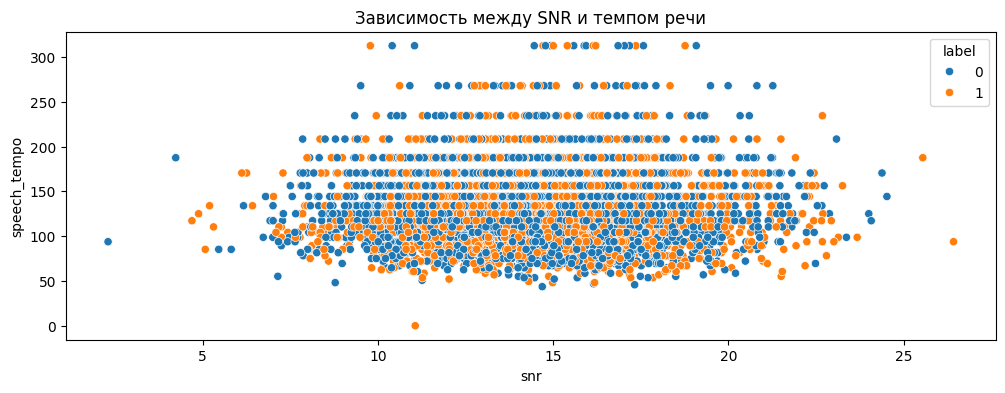

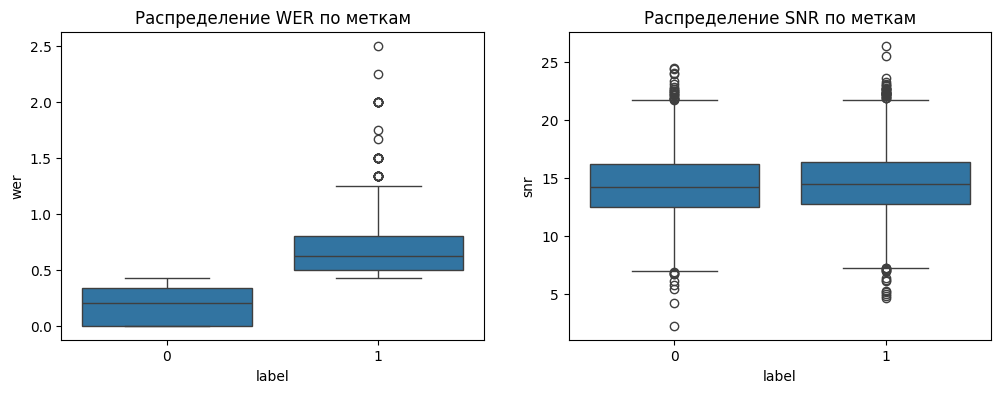

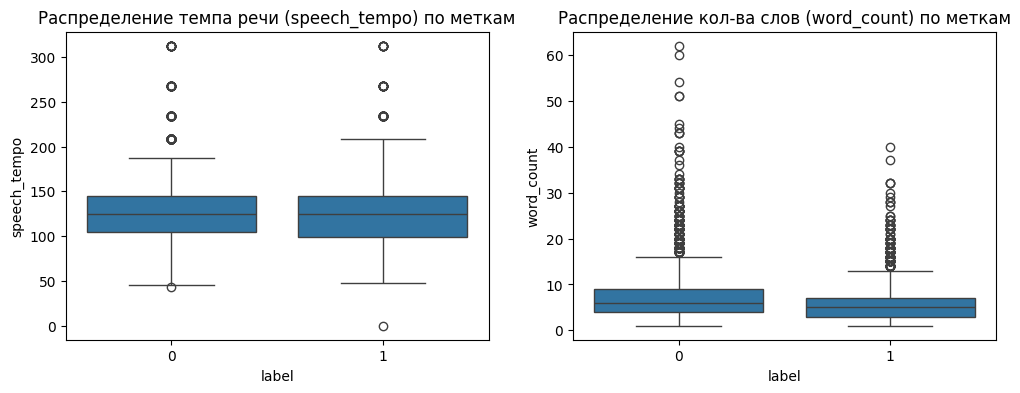

In [55]:
# Создание графиков рассеивания с раскраской по метке 'label'
plt.figure(figsize=(12, 4))
sns.scatterplot(x='snr', y='speech_tempo', hue='label', data=wer2)
plt.title('Зависимость между SNR и темпом речи')


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='wer', data=wer2)
plt.title('Распределение WER по меткам')

plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='snr', data=wer2)
plt.title('Распределение SNR по меткам')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='speech_tempo', data=wer2)
plt.title('Распределение темпа речи (speech_tempo) по меткам')

plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='word_count', data=wer2)
plt.title('Распределение кол-ва слов (word_count) по меткам')

plt.show()


In [46]:
wer2.head()

,model_annotation,human_markup,audio_path,label,wer,audio_path_full,snr,speech_tempo
0,давай по россии значит на коленях быстро блять...,давай проси значит на коленях быстро блять,05a8baf22e2a.wav,1,0.428571,c:\Users\User\Documents\MFTI_2 practice\filter...,11.559509,104.166667
1,ну разве можно так с телефоном поступает,ну что ну разве можно так с телефоном поступать,05a5a51a1e9a.wav,0,0.333333,c:\Users\User\Documents\MFTI_2 practice\filter...,12.490909,234.375000
2,у меня нет с собой в полном адресе я щас дома ...,у меня нет с собой полного адреса я щас из дом...,05a4c4f90c59.wav,0,0.323529,c:\Users\User\Documents\MFTI_2 practice\filter...,12.816182,144.230769
3,а я здесь кто я санитар,а я знаешь кто я санитар,059d08276851.wav,0,0.166667,c:\Users\User\Documents\MFTI_2 practice\filter...,20.201228,144.230769
4,дежурный по кузьминскому военнокомату,дежурный по кузьминскому военкомату,059af3258ca9.wav,0,0.250000,c:\Users\User\Documents\MFTI_2 practice\filter...,10.614436,78.125000


### Статистический анализ
Логистическая регрессия для анализа взаимосвязи между бинарной зависимой переменной и одной или несколькими независимыми переменными.

In [56]:
# Подготовка данных
X = wer2[['snr', 'speech_tempo', 'word_count']]  # Независимые переменные
X = sm.add_constant(X)  # Добавление константы для перехвата
y = wer2['label']  # Зависимая переменная

# Построение логистической регрессии
model = sm.Logit(y, X)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.657071
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 6508
Model:                          Logit   Df Residuals:                     6504
Method:                           MLE   Df Model:                            3
Date:                Sun, 19 May 2024   Pseudo R-squ.:                 0.02394
Time:                        02:00:41   Log-Likelihood:                -4276.2
converged:                       True   LL-Null:                       -4381.1
Covariance Type:            nonrobust   LLR p-value:                 3.301e-45
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2038      0.176      1.160      0.246      -0.140       0.548
snr              0.0112

### Анализ корреляции
Хотя корреляция Пирсона обычно используется для измерения линейной связи между непрерывными переменными,  
для оценки связи между бинарными и непрерывными переменными можно использовать корреляцию пункт-бисериал.

In [59]:
from scipy.stats import pointbiserialr

# Корреляция пункт-бисериал между label и snr
corr_pbs_snr = pointbiserialr(wer2['label'], wer2['snr'])
print(f"Корреляция пункт-бисериал между label и snr: {corr_pbs_snr.correlation}, p-value: {corr_pbs_snr.pvalue}")

# Корреляция пункт-бисериал между label и speech_tempo
corr_pbs_tempo = pointbiserialr(wer2['label'], wer2['speech_tempo'])
print(f"Корреляция пункт-бисериал между label и speech_tempo: {corr_pbs_tempo.correlation}, p-value: {corr_pbs_tempo.pvalue}")

# Корреляция пункт-бисериал между label и word_count
corr_pbs_word = pointbiserialr(wer2['label'], wer2['word_count'])
print(f"Корреляция пункт-бисериал между label и word_count: {corr_pbs_word.correlation}, p-value: {corr_pbs_word.pvalue}")


Корреляция пункт-бисериал между label и snr: 0.04405228359045332, p-value: 0.0003782140994505364
Корреляция пункт-бисериал между label и speech_tempo: -0.008164237917911363, p-value: 0.5102096394566055
Корреляция пункт-бисериал между label и word_count: -0.16535209487232194, p-value: 4.0730482991157345e-41


### Выводы анализа

**Корреляция**  
SNR и Label: корреляция 0.044, p-value: 0.007 (слабая положительная корреляция, статистически значима)  
Темп Речи и Label: корреляция -0.008, p-value: 0.512 (очень слабая отрицательная корреляция, не статистически значима)  
Количество Слов и Label: корреляция -0.165, p-value: <0.0001 (умеренная отрицательная корреляция, статистически значима)  

**Интерпретация и Рекомендации**  
SNR не показал статистической значимости в логистической регрессии, несмотря на небольшую корреляцию.  
Возможно, стоит рассмотреть другие способы его измерения или учет вместе с другими переменными.

Темп речи показывает значимость только в регрессии, но не в корреляции.  
Это может означать, что его влияние на метку label проявляется только в комбинации с другими переменными.

Количество слов является значимым свойством в обоих анализах. Большее количество слов связано с меньшей   
вероятностью того, что label будет 1. Это указывает на то, что ***длинные записи труднее корректно распознать***.

### Сохранение DataFrame в файл Excel

In [60]:
# Сохранение DataFrame в файл Excel
wer2.to_excel('output2.xlsx', index=False)  # Параметр index=False означает, что индексы не будут сохраняться в файле
